# Inicializando

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn

# Base de dados baixada a partir do Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download
# df = pd.read_csv('/content/drive/MyDrive/PD_Onca_Pintada/Projeto/Data/creditcard.csv')
df = pd.read_csv('creditcard.csv') # Versão PC

atributos_a_serem_descartados = ['Time', 'V1', 'V2', 'V6', 'V8', 'V13', 'V15', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
atributos_que_ficaram = ['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19', 'Amount']

#* Atributos importante para a fraude: V3, V4, V5, V7, V9, V10, V11, V12, V14, V16, V17
#* Valores correlacionados negativamente: V17 V14 V12 V10 (Quanto menores mais chances de ser uma fraude)
#* Valores correlacionados positivamente: V2, V4, V11, V19 (Quanto maiores mais chances de ser uma fraude)

#* Atributos importante para o legitimo: V4, Amount

# Atributos que ainda podem ser descartados: V5, V7

df = df.drop(columns = atributos_a_serem_descartados)

print(df.columns)

X = df.to_numpy()

print(len(X[0]))

y = pd.DataFrame(X[:,-1])
X = pd.DataFrame(X[:,:-1])


Index(['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17',
       'V19', 'Amount', 'Class'],
      dtype='object')
14


In [3]:
from sklearn import tree

def get_novo_modelo():
    return tree.DecisionTreeClassifier()

def modelo_fit(modelo, dados, classes):
    return modelo.fit(dados, classes)

def modelo_predict(modelo, dados):
    return modelo.predict(dados)

peso_AUC_validacao = 0.5
peso_AUC_teste = 0.5

# Nested Cross validation

In [13]:
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_recall_curve, auc
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)

skf_outter = StratifiedKFold(n_splits=10)
skf_inner = StratifiedKFold(n_splits=10)

matriz_auc = []
matriz_treino = []
matriz_validacao = []
separacao_treino_geral = []
separacao_teste = []

separa_externa = 0
melhor_separacao_interna = 0
melhor_separacao_externa = 0

for general_train_idx, test_idx in skf_outter.split(X, y):

    X_train = X.loc[general_train_idx]
    y_train = y.loc[general_train_idx]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]

    matriz_auc.append([])
    separacao_treino = []
    separacao_validacao = []
    separa_interna = 0   

    melhor_interno = 0

    for train_idx, val_idx in skf_inner.split(X_train, y_train):

        X_tr = X_train.loc[train_idx]
        y_tr = y_train.loc[train_idx]

        X_val = X_train.loc[val_idx]
        y_val = y_train.loc[val_idx]

        separacao_treino.append(train_idx)
        separacao_validacao.append(val_idx)

        modelo = get_novo_modelo()
        modelo = modelo_fit(modelo, X_tr, y_tr)
        pred = modelo_predict(modelo, X_val)

        precision, recall, _ = precision_recall_curve(y_val, pred)
        auc_score_val = auc(recall, precision)

        pred = modelo_predict(modelo, X_test)
        precision, recall, _ = precision_recall_curve(y_test, pred)
        auc_score_test = auc(recall, precision)
        auc_score = (auc_score_val * peso_AUC_validacao) + (auc_score_test * peso_AUC_teste)
        
        print(f"Separação interna: {separa_interna}, (Val)P/R: {auc_score_val:0.4f}, (Test)P/R: {auc_score_test:0.4f}, (Junto)P/R: {auc_score:0.4f}")

        matriz_auc[separa_externa].append(auc_score)

        if  matriz_auc[melhor_separacao_externa][melhor_separacao_interna] < auc_score:
            melhor_separacao_interna = separa_interna
            melhor_separacao_externa = separa_externa
            melhor_interno = auc_score
        
        if melhor_interno < auc_score:
            melhor_interno = auc_score

        separa_interna += 1   
    
    print(f"Separação externa: {separa_externa}, melhor Precision/Recall desse loop: {melhor_interno:0.4f}")

    matriz_treino.append(separacao_treino.copy())
    matriz_validacao.append(separacao_validacao.copy())
    separacao_treino_geral.append(general_train_idx)
    separacao_teste.append(test_idx)

    separa_externa += 1

Separação interna: 0, (Val)P/R: 0.8483, (Test)P/R: 0.6066, (Junto)P/R: 0.7275
Separação interna: 1, (Val)P/R: 0.8994, (Test)P/R: 0.6798, (Junto)P/R: 0.7896
Separação interna: 2, (Val)P/R: 0.7825, (Test)P/R: 0.6751, (Junto)P/R: 0.7288
Separação interna: 3, (Val)P/R: 0.7570, (Test)P/R: 0.6549, (Junto)P/R: 0.7059
Separação interna: 4, (Val)P/R: 0.4995, (Test)P/R: 0.5369, (Junto)P/R: 0.5182
Separação interna: 5, (Val)P/R: 0.7764, (Test)P/R: 0.6648, (Junto)P/R: 0.7206
Separação interna: 6, (Val)P/R: 0.6895, (Test)P/R: 0.6539, (Junto)P/R: 0.6717
Separação interna: 7, (Val)P/R: 0.6720, (Test)P/R: 0.6265, (Junto)P/R: 0.6493
Separação interna: 8, (Val)P/R: 0.7639, (Test)P/R: 0.6566, (Junto)P/R: 0.7102
Separação interna: 9, (Val)P/R: 0.6053, (Test)P/R: 0.6417, (Junto)P/R: 0.6235
Separação externa: 0, melhor Precision/Recall desse loop: 0.7896
Separação interna: 0, (Val)P/R: 0.5968, (Test)P/R: 0.8105, (Junto)P/R: 0.7036
Separação interna: 1, (Val)P/R: 0.7842, (Test)P/R: 0.5070, (Junto)P/R: 0.6456

In [15]:
X_test = X.loc[separacao_teste[melhor_separacao_externa]]
y_test = y.loc[separacao_teste[melhor_separacao_externa]]

X_treino_geral = X.loc[separacao_treino_geral[melhor_separacao_externa]]
y_treino_geral = y.loc[separacao_treino_geral[melhor_separacao_externa]]

X_treino_geral = X_treino_geral.reset_index(drop=True)
y_treino_geral = y_treino_geral.reset_index(drop=True)

X_tr = X_treino_geral.loc[matriz_treino[melhor_separacao_externa][melhor_separacao_interna]]
y_tr = y_treino_geral.loc[matriz_treino[melhor_separacao_externa][melhor_separacao_interna]]

X_val = X_treino_geral.loc[matriz_validacao[melhor_separacao_externa][melhor_separacao_interna]]
y_val = y_treino_geral.loc[matriz_validacao[melhor_separacao_externa][melhor_separacao_interna]]

auc_score = 0

# Re-treinamento com a melhor divisão
while matriz_auc[melhor_separacao_externa][melhor_separacao_interna] > auc_score:
    modelo = get_novo_modelo()
    modelo = modelo_fit(modelo, X_tr, y_tr)
    pred = modelo_predict(modelo, X_val)

    precision, recall, _ = precision_recall_curve(y_val, pred)
    auc_score_val = auc(recall, precision)

    pred = modelo_predict(modelo, X_test)
    precision, recall, _ = precision_recall_curve(y_test, pred)
    auc_score_test = auc(recall, precision)
    auc_score = (auc_score_val * peso_AUC_validacao) + (auc_score_test * peso_AUC_teste)
    
    print(f"Precision/Recall: {auc_score:0.4f}, Esperado: {matriz_auc[melhor_separacao_externa][melhor_separacao_interna]}")

pred = modelo_predict(modelo, X_val)
precision, recall, _ = precision_recall_curve(y_val, pred)
auc_score_val = auc(recall, precision)

pred = modelo_predict(modelo, X_test)
precision, recall, _ = precision_recall_curve(y_test, pred)
auc_score_test = auc(recall, precision)
auc_score = (auc_score_val * peso_AUC_validacao) + (auc_score_test * peso_AUC_teste)

print(f"(Val)P/R: {auc_score_val:0.4f}, (Test)P/R: {auc_score_test:0.4f}, (Junto)P/R: {auc_score:0.4f}")

Precision/Recall: 0.7883, Esperado: 0.8561758416692051
Precision/Recall: 0.8194, Esperado: 0.8561758416692051
Precision/Recall: 0.8315, Esperado: 0.8561758416692051
Precision/Recall: 0.8494, Esperado: 0.8561758416692051
Precision/Recall: 0.8194, Esperado: 0.8561758416692051
Precision/Recall: 0.8263, Esperado: 0.8561758416692051
Precision/Recall: 0.8375, Esperado: 0.8561758416692051
Precision/Recall: 0.8619, Esperado: 0.8561758416692051
(Val)P/R: 0.8456, (Test)P/R: 0.8783, (Junto)P/R: 0.8619


# Analise a partir da separação

In [16]:
tamanho_eixoX = 20
tamanho_eixoY = 10

X_tr = X_tr.to_numpy()
y_tr = y_tr.to_numpy()

X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

X_testing = X_test.to_numpy()
y_testing = y_test.to_numpy()

### Treino: Acerto e Erro

Taxa de acerto: 1.0


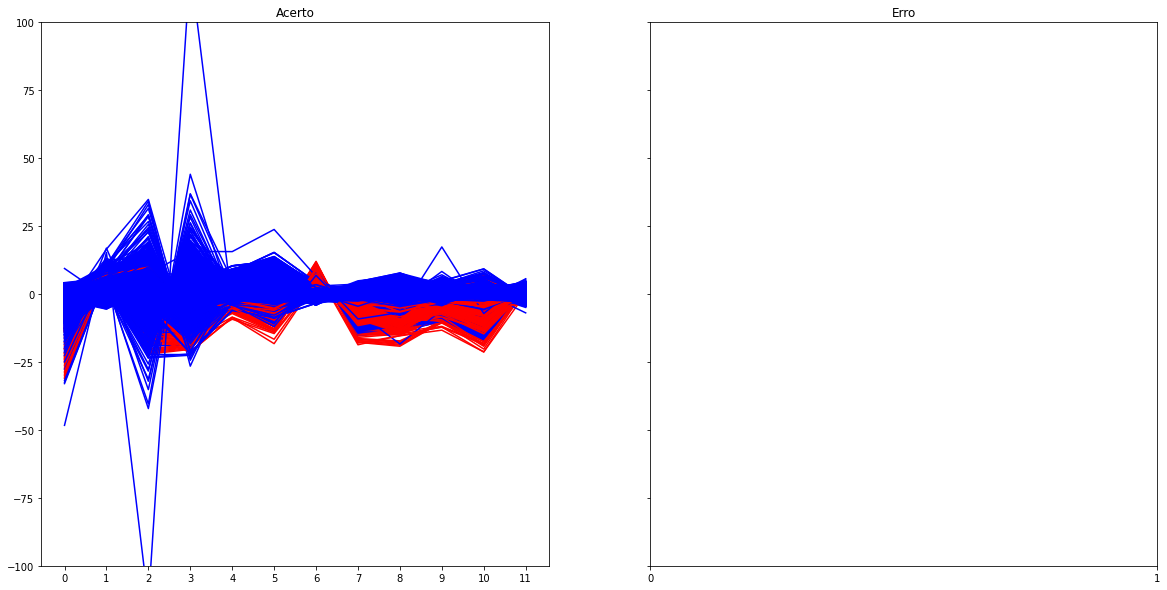

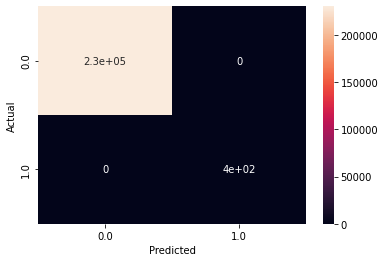

In [17]:
fig, (acerto, erro) = plt.subplots(1, 2, sharey=True, figsize=(tamanho_eixoX, tamanho_eixoY))

acerto.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))
erro.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))

acerto.set_title("Acerto")
erro.set_title("Erro")

contador_acertos = 0
predicao = modelo_predict(modelo, X_tr)
i = 0
for pred in predicao:
  if pred == y_tr[i]:
    contador_acertos += 1
    if y_tr[i] == 0:
      acerto.plot(X_tr[i,:-1], '-b')
    else:
      acerto.plot(X_tr[i,:-1], '-r')
  else:
    if y_tr[i] == 0:
      erro.plot(X_tr[i,:-1], '-b')
    else:
      erro.plot(X_tr[i,:-1], '-r')
  i += 1
      
print(f"Taxa de acerto: {contador_acertos/len(X_tr)}")
plt.ylim([-100,100])
plt.show()

confusion_matrix = pd.crosstab(y_tr.reshape(1, len(y_tr)), predicao, rownames=['Actual'], colnames=['Predicted']);
sn.heatmap(confusion_matrix, annot=True);

### Validacao: Acerto e Erro

Taxa de acerto: 0.9993758046268482


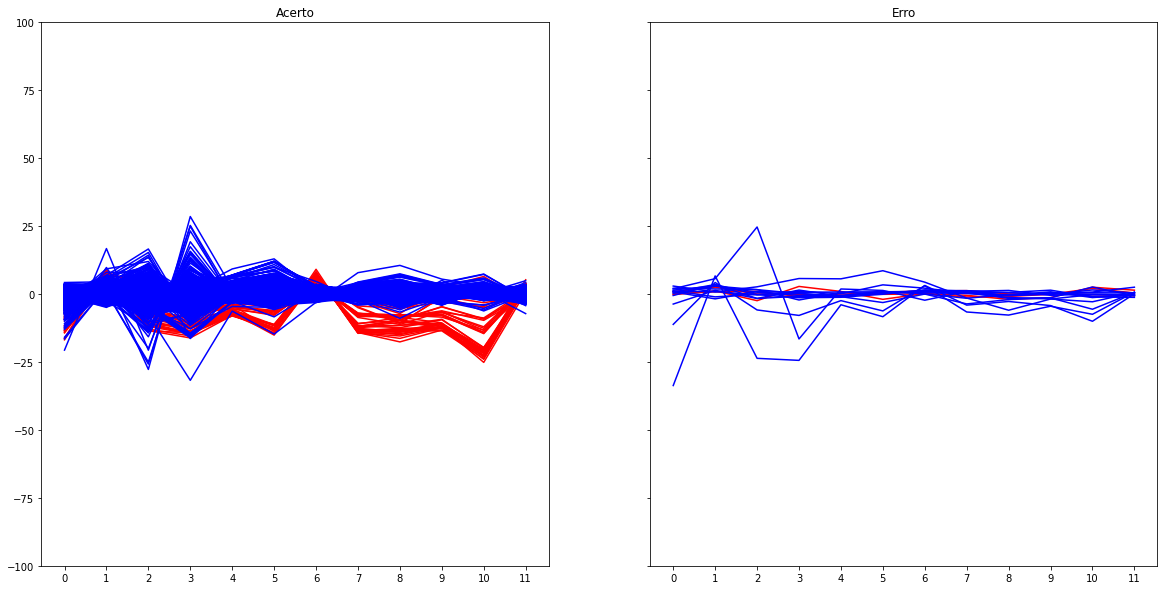

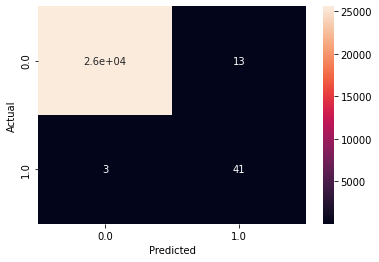

In [18]:
fig, (acerto, erro) = plt.subplots(1, 2, sharey=True, figsize=(tamanho_eixoX, tamanho_eixoY))

acerto.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))
erro.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))

acerto.set_title("Acerto")
erro.set_title("Erro")

contador_acertos = 0

predicao = modelo_predict(modelo, X_val)
i = 0

colunas_dataframe = ['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19']
dt_v = pd.DataFrame(X_val[:, :-1], columns=colunas_dataframe)

for pred in predicao:
  if pred == y_val[i]:
    contador_acertos += 1
    if y_val[i] == 0:
      acerto.plot(X_val[i,:-1], '-b')
    else:
      acerto.plot(X_val[i,:-1], '-r')
  else:
    if y_val[i] == 0:
      erro.plot(X_val[i,:-1], '-b')
    else:
      erro.plot(X_val[i,:-1], '-r')

  i += 1

print(f"Taxa de acerto: {contador_acertos/len(X_val)}")
plt.ylim([-100,100])
plt.show()

confusion_matrix = pd.crosstab(y_val.reshape(1, len(y_val)), predicao, rownames=['Actual'], colnames=['Predicted']);
sn.heatmap(confusion_matrix, annot=True);

### Teste: Acerto e Erro

Taxa de acerto: 0.9995435553526912


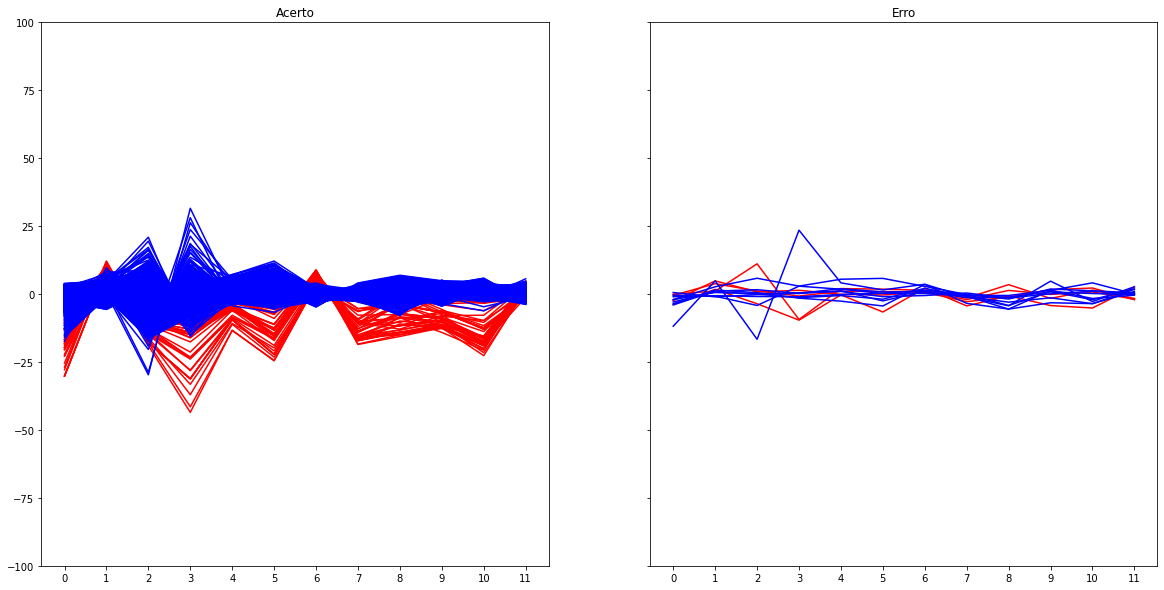

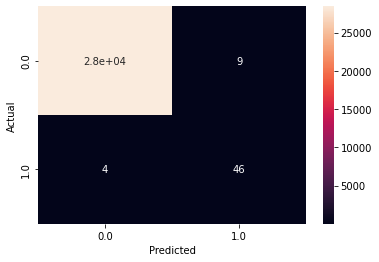

In [19]:
fig, (acerto, erro) = plt.subplots(1, 2, sharey=True, figsize=(tamanho_eixoX, tamanho_eixoY))

acerto.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))
erro.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))

acerto.set_title("Acerto")
erro.set_title("Erro")

contador_acertos = 0
predicao = modelo_predict(modelo, X_testing)
i = 0
for pred in predicao:
  if pred == y_testing[i]:
    contador_acertos += 1
    if y_testing[i] == 0:
      acerto.plot(X_testing[i,:-1], '-b')
    else:
      acerto.plot(X_testing[i,:-1], '-r')
  else:
    if y_testing[i] == 0:
      erro.plot(X_testing[i,:-1], '-b')
    else:
      erro.plot(X_testing[i,:-1], '-r')
  i += 1
      
print(f"Taxa de acerto: {contador_acertos/len(X_testing)}")
plt.ylim([-100,100])
plt.show()

confusion_matrix = pd.crosstab(y_testing.reshape(1, len(y_testing)), predicao, rownames=['Actual'], colnames=['Predicted']);
sn.heatmap(confusion_matrix, annot=True);

# Salvamento manual

In [28]:
#break

df = pd.read_csv('creditcard.csv')
colunas_dataframe = list(df.columns.values)

X_test = df.loc[separacao_teste[melhor_separacao_externa]]

X_treino_geral = df.loc[separacao_treino_geral[melhor_separacao_externa]]

X_treino_geral = X_treino_geral.reset_index(drop=True)

X_tr = X_treino_geral.loc[matriz_treino[melhor_separacao_externa][melhor_separacao_interna]]

X_val = X_treino_geral.loc[matriz_validacao[melhor_separacao_externa][melhor_separacao_interna]]

df_train = pd.DataFrame(X_tr, columns=colunas_dataframe)

df_val = pd.DataFrame(X_val, columns=colunas_dataframe)

df_test = pd.DataFrame(X_test, columns=colunas_dataframe)

df_train.to_csv('./treino.csv')
df_val.to_csv('./validacao.csv')
df_test.to_csv('./teste.csv')